In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
import matplotlib.cm as cm

import scipy.signal as signal

from numba import jit

random_state = 0 # Magic

# Renaming columns, joining
Join by frame number

In [2]:
df_fish0 = pd.read_csv('../../data/raw/zebrafish26.01.2017_fish0.csv')
df_fish1 = pd.read_csv('../../data/raw/zebrafish26.01.2017_fish1.csv')

In [3]:
df_fish0.columns

Index(['frame', 'ACCELERATION#pcentroid (cm/s2)', 'ANGLE', 'AX', 'AY',
       'BORDER_DISTANCE#pcentroid (cm)', 'NEIGHBOR_DISTANCE (cm)',
       'SPEED#pcentroid (cm/s)', 'VX (cm/s)', 'VY (cm/s)', 'X (cm)', 'Y (cm)',
       'time#centroid'],
      dtype='object')

In [4]:
cols = ['frame', 'acceleration', 'angle', 'aX', 'aY',
       'border_distance', 'neighbor_distance',
       'speed', 'vX', 'vY', 'x', 'y',
       'time']
df_fish0.columns = cols
df_fish1.columns = cols

In [5]:
df_total = df_fish0.set_index('frame').join(df_fish1, lsuffix='_f0', rsuffix='_f1' )

In [6]:
df_total.columns

Index(['acceleration_f0', 'angle_f0', 'aX_f0', 'aY_f0', 'border_distance_f0',
       'neighbor_distance_f0', 'speed_f0', 'vX_f0', 'vY_f0', 'x_f0', 'y_f0',
       'time_f0', 'frame', 'acceleration_f1', 'angle_f1', 'aX_f1', 'aY_f1',
       'border_distance_f1', 'neighbor_distance_f1', 'speed_f1', 'vX_f1',
       'vY_f1', 'x_f1', 'y_f1', 'time_f1'],
      dtype='object')

## Dedup columns
Some columns are duplicate, e.g. time, neighbour distance

In [7]:
df_total.drop(['time_f1', 'neighbor_distance_f1'], axis=1, inplace=True)
df_total.rename(columns={'time_f0': 'time', 'neighbor_distance_f0': 'neighbor_distance'}, inplace=True)
df_total = df_total.replace([np.inf, -np.inf], np.nan).dropna()
df = df_total

In [8]:
df.describe()

,acceleration_f0,angle_f0,aX_f0,aY_f0,border_distance_f0,neighbor_distance,speed_f0,vX_f0,vY_f0,x_f0,...,acceleration_f1,angle_f1,aX_f1,aY_f1,border_distance_f1,speed_f1,vX_f1,vY_f1,x_f1,y_f1
count,958966.000000,958966.000000,958966.000000,958966.000000,958966.000000,958966.000000,958966.000000,958966.000000,958966.000000,958966.000000,...,958966.000000,958966.000000,958966.000000,958966.000000,958966.000000,958966.000000,958966.000000,958966.000000,958966.000000,958966.000000
mean,19.707095,0.026415,13.131483,12.994123,19.707098,8.946072,1.943691,0.000089,-0.000441,13.131483,...,21.749133,0.085185,14.395056,14.207710,21.749138,2.816721,-0.001979,-0.002315,14.395056,14.207710
std,6.540574,1.903960,6.798111,6.582415,6.540584,6.831658,1.859761,2.253892,2.267216,6.798123,...,7.518722,1.880628,7.697266,7.838720,7.518736,2.557842,2.773980,2.854870,7.697282,7.838736
min,7.644270,-3.141580,1.182210,1.261620,7.641350,0.174975,0.000000,-88.169300,-77.417600,1.177870,...,7.620940,-3.141580,1.179160,1.271510,7.596140,0.000000,-80.380500,-82.293500,1.173200,1.164470
25%,14.463025,-1.698327,7.258622,7.817835,14.463325,2.908008,0.603504,-0.775282,-0.733994,7.258550,...,15.377100,-1.622630,7.741730,7.408245,15.377000,0.916967,-1.027825,-0.990365,7.741713,7.408333
50%,18.278550,0.024909,12.332900,12.190000,18.278400,6.753610,1.328400,-0.063948,0.009766,12.332900,...,20.969100,0.157296,14.089100,13.808750,20.968750,2.024175,-0.080078,0.044371,14.089550,13.808650
75%,24.451750,1.751292,18.351600,17.713275,24.451575,14.288500,2.678667,0.673047,0.751512,18.351900,...,28.599900,1.762338,20.631300,20.630075,28.600300,4.016400,0.921875,1.025000,20.631575,20.630075
max,35.023100,3.141590,28.809400,28.897000,35.026700,27.319700,28.494500,76.657200,79.307800,28.812300,...,35.126700,3.141590,28.857300,29.025800,35.129600,38.355700,92.714100,78.464100,28.905900,29.032000


In [9]:
def smooth(x):
    
    # TODO: Use proper values
    degree = 3
    time_window = 18 # change to be 0.36s window
    bandwidth = 4 # change to be 0.08s
    # Smooth speed
    
    #shape = x.shape[:-1] + (x.shape[-1] - window + 1, window)
    #strides = x.strides + (x.strides[-1],)
    #windowed = np.lib.stride_tricks.as_strided(x, shape=shape, strides=strides)
    x = signal.savgol_filter(x, window_length=51, polyorder=degree) # TODO: Check
    
    return x

0.00758036007571 0.00398891042878
[ 2.76757649  2.74722896  2.71851125 ...,  0.75498638  0.58659098
  0.39730367]


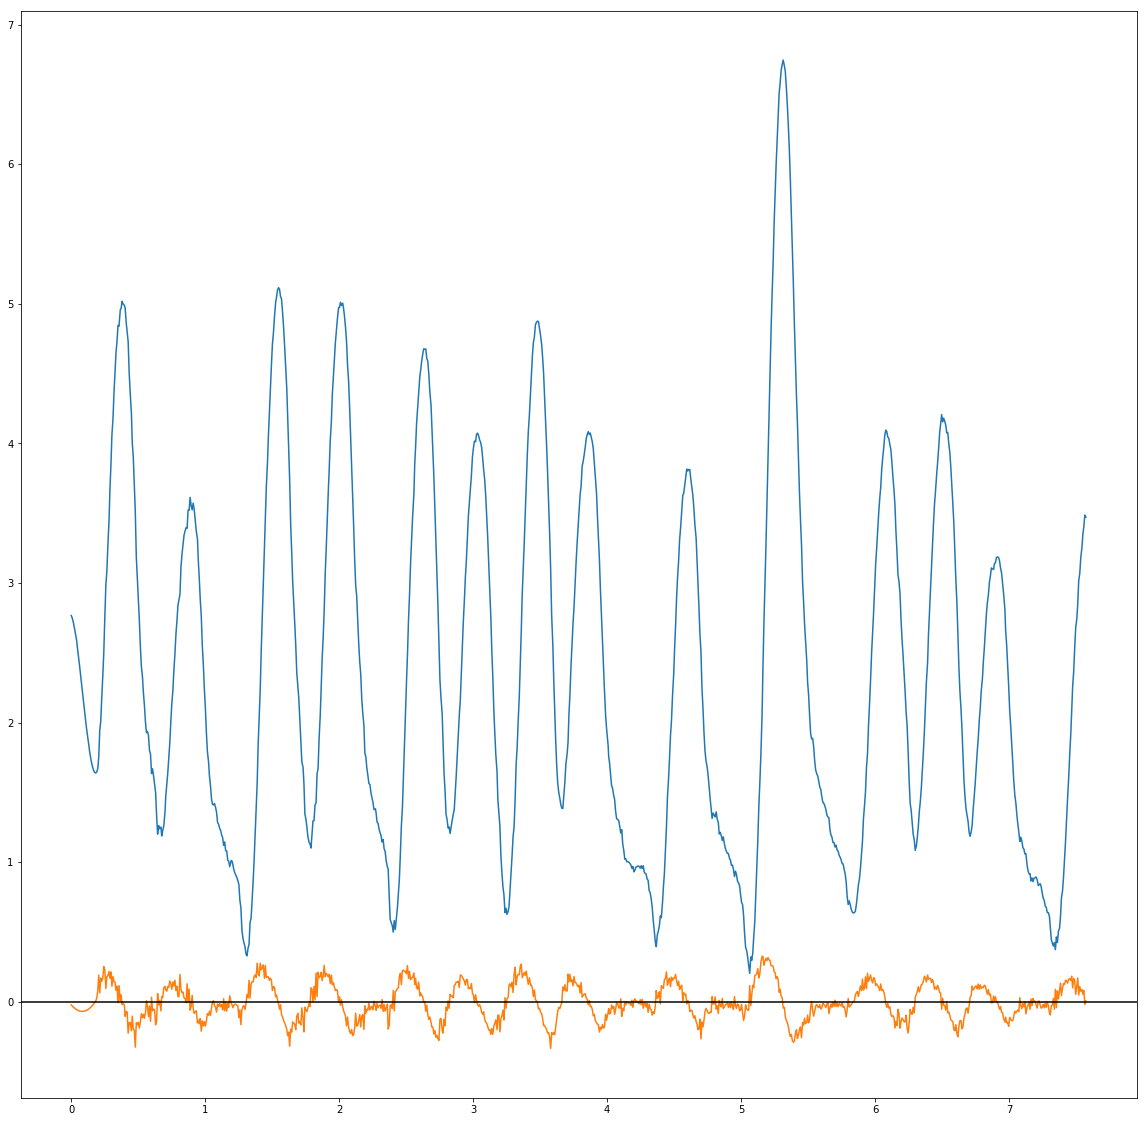

In [92]:
vel0 = df['speed_f0'].values
vel1 = df['speed_f1'].values
vel0_smooth = smooth(vel0)
vel1_smooth = smooth(vel1)
acc0 = np.ediff1d(vel0_smooth)
time = df['time'].values[:]
time_diff = np.ediff1d(time)
print(np.mean(time_diff), np.std(time_diff))
print(vel0_smooth)

till = 1000
fig, ax = plt.subplots(figsize=(20,20))
#ax.plot(time[:till], s0[:till])
ax.plot(time[:till], vel0_smooth[:till])
ax.plot(time[:till], acc0[:till])
ax.axhline(0, color='black', )

In [93]:
SWIMMING = 0
PAUSING = 1
STOPPING = 2
UNDET = 42

# Irregular timesteps
@jit(nopython=True)
def get_status(vel0, vel1, time, threshold):
    
    time_window = 4.0 #TODO: Change to 4
    vel_max = np.maximum(vel0, vel1)
    #print(vel_max)
    status = (vel_max <= threshold) * UNDET # swimming has correct values for swimming
    
    i = 0
    while i < len(vel_max):
        cur_time = time[i]
        
        if status[i] == SWIMMING:
            i += 1
            continue
            
        # TODO: Change to start from idx i (don't forget the offset i!)
        # Index for next entry where time_window time has elapsed
        # Beware: If not found, will be i!
        next_time_idx = np.argmax(time[i:] >= cur_time + time_window) + i
        
        # Index for next swimming
        next_swimming_idx = np.argmax(status[i:] == SWIMMING) + i
        
        #print(next_time_idx, next_swimming_idx, i)
        
        # If one of both indexes is <= i; reached end of array. all entries are pausing or swimming
        # maybe small bug
        if next_time_idx == i or next_swimming_idx < i:
            print("Reached the end!")
            to_change = np.where( status[i : ] != SWIMMING)            
            status[i:][to_change] = PAUSING
            break
                        
        # If any of those are SWIMMING, movement has only paused!
        if np.any(status[i : next_time_idx] == SWIMMING):
            cur_status = PAUSING
            status[i] = cur_status
            i = i + 1
            
        # Otherwise we have stopped
        else:
            cur_status = STOPPING
            upper = max(next_time_idx, next_swimming_idx)
            to_change = np.where( status[i : upper] != SWIMMING)
            status[i:upper][to_change] = cur_status
            
            # Skip some iterations
            i = max(i+1, max(next_time_idx, next_swimming_idx))
                
    return status

In [94]:
threshold = 5 # TODO: Find reasonable threshold
#print(time[:100])
s = get_status(vel0_smooth[0:3200], vel1_smooth[0:3200], time[0:3200], threshold)

Reached the end!


In [96]:
print(s)
print(vel0.shape, vel1.shape, time.shape, s.shape, np.mean(s), np.max(s))
for i in range(0,3):
    print(i, len(np.where(s == i)[0]))

[1 1 1 ..., 1 1 1]
(958966,) (958966,) (958966,) (3200,) 1.2775 2
0 218
1 1876
2 1106


In [97]:
acc0[0:100]

array([-0.02034753, -0.02871771, -0.03626222, -0.04298107, -0.04887426,
       -0.05394179, -0.05818365, -0.06159986, -0.0641904 , -0.06595528,
       -0.06689449, -0.06700805, -0.06629594, -0.06475818, -0.06239475,
       -0.05920565, -0.0551909 , -0.05035048, -0.0446844 , -0.03819266,
       -0.03087526, -0.0227322 , -0.01376347, -0.00396909,  0.00665096,
        0.02526286,  0.08144229,  0.19209478,  0.06596088,  0.17224527,
        0.1497435 ,  0.17093712,  0.2542642 ,  0.23081159,  0.09624186,
        0.18274632,  0.1881679 ,  0.2190923 ,  0.1694149 ,  0.21570415,
        0.11361116,  0.18432349,  0.14508017,  0.14384552,  0.08362372,
        0.11432538, -0.00552341,  0.11746783,  0.00834933,  0.0513966 ,
       -0.01868914, -0.0091347 , -0.01964172, -0.10226257, -0.06717562,
       -0.07160941, -0.2231256 , -0.14766563, -0.14622855, -0.20570098,
       -0.10056207, -0.19305635, -0.20051892, -0.3229056 , -0.1482252 ,
       -0.163206  , -0.14466059, -0.18611375, -0.14088132, -0.08

In [104]:
# Find acc phases
ACCELERATING = 1
GLIDING = 0

def segmentation(acc, time):
    phases = (acc > 0.0) * ACCELERATING
    # TODO (maybe): fuse back nearby accelerating events
    return phases    

In [105]:
segmentation(acc0, time)[0:50], acc0[0:50]

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        0, 1, 1, 1]),
 array([-0.02034753, -0.02871771, -0.03626222, -0.04298107, -0.04887426,
        -0.05394179, -0.05818365, -0.06159986, -0.0641904 , -0.06595528,
        -0.06689449, -0.06700805, -0.06629594, -0.06475818, -0.06239475,
        -0.05920565, -0.0551909 , -0.05035048, -0.0446844 , -0.03819266,
        -0.03087526, -0.0227322 , -0.01376347, -0.00396909,  0.00665096,
         0.02526286,  0.08144229,  0.19209478,  0.06596088,  0.17224527,
         0.1497435 ,  0.17093712,  0.2542642 ,  0.23081159,  0.09624186,
         0.18274632,  0.1881679 ,  0.2190923 ,  0.1694149 ,  0.21570415,
         0.11361116,  0.18432349,  0.14508017,  0.14384552,  0.08362372,
         0.11432538, -0.00552341,  0.11746783,  0.00834933,  0.0513966 ]))

In [20]:
df_total.columns

Index(['acceleration_f0', 'angle_f0', 'aX_f0', 'aY_f0', 'border_distance_f0',
       'neighbor_distance', 'speed_f0', 'vX_f0', 'vY_f0', 'x_f0', 'y_f0',
       'time', 'frame', 'acceleration_f1', 'angle_f1', 'aX_f1', 'aY_f1',
       'border_distance_f1', 'speed_f1', 'vX_f1', 'vY_f1', 'x_f1', 'y_f1'],
      dtype='object')